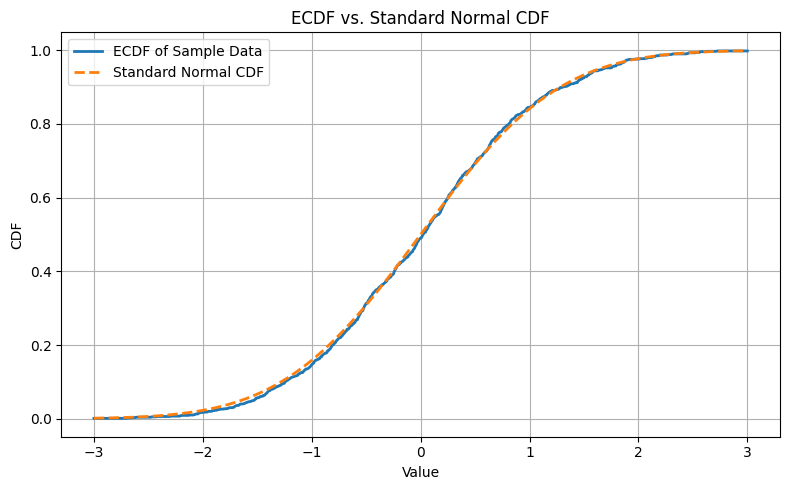

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import special  # Import the special module from SciPy

# Simulate sample data from a standard normal distribution
np.random.seed(42)
sample_data = np.random.normal(loc=0, scale=1, size=1000)

# Compute the empirical CDF (ECDF)
ecdf = sm.distributions.ECDF(sample_data)
x = np.linspace(-3, 3, 1000)
y_ecdf = ecdf(x)

# Compute the theoretical CDF for a standard normal distribution
# Use special.erf from SciPy
y_theoretical = 0.5 * (1 + special.erf(x / np.sqrt(2)))

# Plot both curves
plt.figure(figsize=(8, 5))
plt.plot(x, y_ecdf, label='ECDF of Sample Data', lw=2)
plt.plot(x, y_theoretical, label='Standard Normal CDF', lw=2, linestyle='--')
plt.xlabel('Value')
plt.ylabel('CDF')
plt.title('ECDF vs. Standard Normal CDF')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('ecdf_vs_normal_cdf.png', dpi=300)
plt.show()

In [ ]:
!pip install --upgrade transformers


In [ ]:

!pip uninstall -y bitsandbytes
!pip install --no-cache-dir --upgrade bitsandbytes==0.45.5


In [ ]:
import os, torch, pandas as pd, matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import (
    GPT2LMHeadModel, GPT2Tokenizer,
    AutoModelForCausalLM, AutoTokenizer,
    BitsAndBytesConfig, Trainer, TrainingArguments
)
from peft import LoraConfig, get_peft_model


os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
MAX_LENGTH = 128


ds = load_dataset("wikitext", "wikitext-2-raw-v1")
def prep(tokenizer):
    def fn(batch):
        out = tokenizer(batch["text"], truncation=True, padding="max_length",
                        max_length=MAX_LENGTH)
        out["labels"] = out["input_ids"].copy()
        return out
    return fn

# 2.1 QLoRA run
QLORA_TOKEN   = "  "
QLORA_MODEL   = "meta-llama/Llama-3.2-3B"
QLORA_OUTDIR  = "qlora_llama32b"

qlora_tok = AutoTokenizer.from_pretrained(QLORA_MODEL, use_auth_token=QLORA_TOKEN,
                                          trust_remote_code=True, legacy=False)
qlora_tok.pad_token = qlora_tok.eos_token
qlora_train = ds["train"].map(prep(qlora_tok), batched=True, remove_columns=["text"])
qlora_val   = ds["validation"].map(prep(qlora_tok), batched=True, remove_columns=["text"])
qlora_train.set_format("torch"); qlora_val.set_format("torch")
# 2.2 model + PEFT
bnb = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4",
                         bnb_4bit_use_double_quant=True)
qlora_model = AutoModelForCausalLM.from_pretrained(
    QLORA_MODEL, quantization_config=bnb,
    device_map={"":torch.cuda.current_device()},
    trust_remote_code=True, use_auth_token=QLORA_TOKEN
)
lcfg = LoraConfig(task_type="CAUSAL_LM", inference_mode=False,
                  r=8, lora_alpha=16, lora_dropout=0.05)
qlora_model = get_peft_model(qlora_model, lcfg)
# 2.3 trainer & train
qlora_args = TrainingArguments(
    output_dir=QLORA_OUTDIR, overwrite_output_dir=True,
    num_train_epochs=1, eval_steps=500, save_steps=500, logging_steps=50,
    fp16=True, learning_rate=1e-4,
    per_device_train_batch_size=2, per_device_eval_batch_size=2,
    gradient_accumulation_steps=8, save_total_limit=2, report_to="none"
)
qlora_trainer = Trainer(
    model=qlora_model, args=qlora_args,
    train_dataset=qlora_train, eval_dataset=qlora_val
)
print("🚀 Starting QLoRA…")
qlora_trainer.train()
# 2.4 save
qlora_trainer.save_model(f"{QLORA_OUTDIR}/adapters")
pd.DataFrame(qlora_trainer.state.log_history).to_csv(
    f"{QLORA_OUTDIR}/log_history.csv", index=False
)


# 3.1 GPT‑2 run
GPT2_MODEL   = "gpt2"
GPT2_OUTDIR  = "gpt2_scratch"

g2_tok = GPT2Tokenizer.from_pretrained(GPT2_MODEL)
g2_tok.pad_token = g2_tok.eos_token
g2_train = ds["train"].map(prep(g2_tok), batched=True, remove_columns=["text"])
g2_val   = ds["validation"].map(prep(g2_tok), batched=True, remove_columns=["text"])
g2_train.set_format("torch"); g2_val.set_format("torch")
# 3.2 model
g2_model = GPT2LMHeadModel.from_pretrained(GPT2_MODEL)
g2_model.gradient_checkpointing_enable()
# 3.3 trainer & train
g2_args = TrainingArguments(
    output_dir=GPT2_OUTDIR, overwrite_output_dir=True,
    num_train_epochs=1, eval_steps=500, save_steps=500, logging_steps=50,
    fp16=True, learning_rate=3e-4,
    per_device_train_batch_size=16, per_device_eval_batch_size=16,
    gradient_accumulation_steps=1, save_total_limit=2, report_to="none"
)
g2_trainer = Trainer(
    model=g2_model, args=g2_args,
    train_dataset=g2_train, eval_dataset=g2_val
)
print("🚀 Starting GPT‑2 scratch…")
g2_trainer.train()
# 3.4 save
g2_trainer.save_model(GPT2_OUTDIR)
pd.DataFrame(g2_trainer.state.log_history).to_csv(
    f"{GPT2_OUTDIR}/log_history.csv", index=False
)


# 4 Visualization
def plot_logs(name, log_csv):
    df = pd.read_csv(log_csv)
    # approximate epoch if missing
    if "epoch" not in df.columns:
        df["epoch"] = df.step / df.step.max()
    # train‐loss
    tdf = df[df.loss.notna()][["step","loss"]].drop_duplicates("step")
    plt.plot(tdf.step, tdf.loss, label=f"{name} train")
    # eval‐ppl
    edf = df[df.eval_loss.notna()][["step","eval_loss"]].drop_duplicates("step")
    edf["ppl"] = edf.eval_loss.map(lambda x: torch.exp(torch.tensor(x)).item())
    plt.plot(edf.step, edf.ppl, marker="o", linestyle="--", label=f"{name} eval ppl")


plt.figure(figsize=(8,4))
plot_logs("QLoRA", f"{QLORA_OUTDIR}/log_history.csv")
plot_logs("GPT2", f"{GPT2_OUTDIR}/log_history.csv")
plt.xlabel("Step"); plt.ylabel("Loss / Perplexity")
plt.yscale("log")
plt.title("QLoRA vs GPT‑2 Small")
plt.legend(); plt.grid(); plt.show()
